# Visualizing Bag of Words(BOW) on Amazon Fine Food Review Dataset

#### 1.Import statements

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

# !pip install -U gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import re
import os


#### 2. Connecting to the Database file using pandas library and retriving the data from 'CleanedText' column

* This Data is the result of the data pre-processing in the 'Data Pre-processing for t-SNE on Amazon Review Dataset.ipynb' file on the Amazon Fine Food Review Dataset. The review data from the original dataset is processed(cleaned) and stored in the same db file for further use.



In [2]:
#Access reviews data from 'final.sqlite' file
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

####  3. Dimensionality reduction of the BOW Vectors for Review text using t-SNE in Scikit-Learn

* Applying the BOW on processed data in 'CleanedText' column yeilds us the sparse matrix representation of the review data.

* BOW is applied to only first 10000 datapoints in the dataset because of several factors such as Memory limitations in the machine, lack of raw processing power and intermittent 'Kernal is dead' issue at higher number of datapoints.

* 'Kernal is dead' issue is primarily because high memory usage by BOW i.e., BOW produces a very large sparse matrix and for a single data point and certainly requires a huge amount of memory in case of very large number of datapoints. This again is not the end objective, when the next steps are carried out, ex: t-SNE; the kernel is dying due to lack of memory in best cases it'll plot the t-SNE vector after 6-8hrs of time for only 2-3k datapoints.

In [3]:
#BoW
final = final[0:10000]
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 12117)
the number of unique words  12117


* A Sparse matrix is obtained as a result of BOW.
* The dimensionality of Sparse matrix obtained after applying BOW on Review text('CleanedText' column) is (364171, 71624).

### Plotting the dimensionality reduced matrix produced by t-SNE using Seaborn

#### Steps:

* Import 'MulticoreTSNE'. The advantages of 'MulticoreTSNE' over normal t-SNE is explained in the below link [1]. In a very laymanish terms, MulticoreTSNE uses specified number of processor cores compared to only single core in normal t-SNE. This has a very dramatic effect on the time elapsed for generating the results.

* Convert the Sparse matrix to Dense Matrix as t-SNE accepts only dense matrix for dimensionality reduction

* Obtain the labels of the first 10000 points from the 'Scores' column in the dataset. This will be crucial in determining the datapoints characteristics such as how well the points are distributed/segregated, the range of the positive/negative points in the plot, clustering of the points in each category. Athough, As the number of points goes high, it's very very hard to determine the data characteristics just from the plot because more number of points tend to overlap and cause more ambiguity.

* Standardize the data from the data using 'StandardScaler' from 'sklearn.preprocessing' package. This is just to make the data mean centered.

* After Standardizing the data, initialize a MulticoreTSNE model with following parameters:
    
        1) n_jobs: Number of processor cores to be used by MulticoreTSNE model. Ex: n_jobs = 8
    
        2) n_components: Dimension of the embedded space i.e., the Dimension of the resulting matrix from t-SNE.
        Ex: n_components=2
    
        3) random_state=0
    
        4) perplexity: The perplexity is related to the number of nearest neighbors that is used in other manifold
        learning algorithms. Larger datasets usually require a larger perplexity. Ex:perplexity = 50, 75 and 100
    
        5) n_iter: Maximum number of iterations for the optimization. Ex:n_iter=5000



* Now fit the BOW dense vector data with the t-SNE model and obatain the 2D data as a result.

* Now construct a new dataframe with obtained data and the labels which will help for plotting.

* Plot the graph of the 2D data using Seaborn library and color positive labels in one color and negative labels in other.

* Obtain the plots for different perplexities with maximum number of iterations.

##### Note: 1) As far as the parameters 'perplexity' and 'n_iter' are considered, there is no right perplexity and n_iter for a given dataset. One must try various perplexities before concluding the distribution of the data. Perplexities for any dataset can range from as low as 10 and can go higher as one want but as we reach the perplexity value close to the number of points the plot get meaningless and looks worse than plotting the original dataset. This is because t-SNE tries to maintain the local geometry of the point in the plot and if the perplexity is close to the datapoints means it tries preserve the geometry of all the poits and fails miserably. This is better explained in the below link[2]


###### 2) n_iter or Maximum number of iterations should as more as possible in order to get a very stabilized plot. As t-SNE is a stochastic/probablistic algorithm, meaning it produces a slightly differernt plot at different number of iterations and it'll stabilze the plot after certain number of points. This certain number of points are intuitively considered to be around 3000 to 5000.


[1] MulticoreTSNE link: https://github.com/DmitryUlyanov/Multicore-TSNE

[2] Christopher Olah's blog on Visualizing-MNIST dataset- An Exploration of Dimensionality Reduction: http://colah.github.io/posts/2014-10-Visualizing-MNIST/

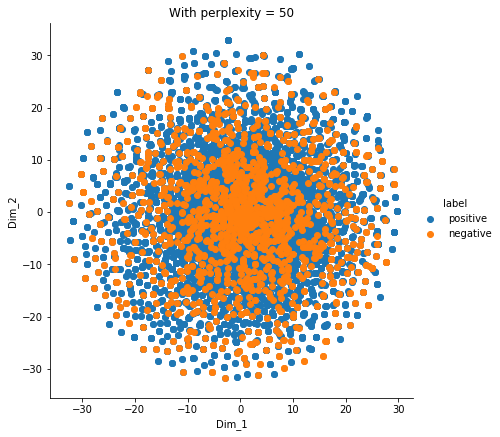

In [4]:
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

data_5000 = final_counts
top_5000 = data_5000.toarray()
labels = final['Score']
labels_5000 = labels[0:10000]


# Standardize the data 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
top_5000 = sc.fit_transform(top_5000)


model = TSNE(n_jobs = 8, n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = model.fit_transform(top_5000)

# creating a new data frame for ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 50')
plt.show()

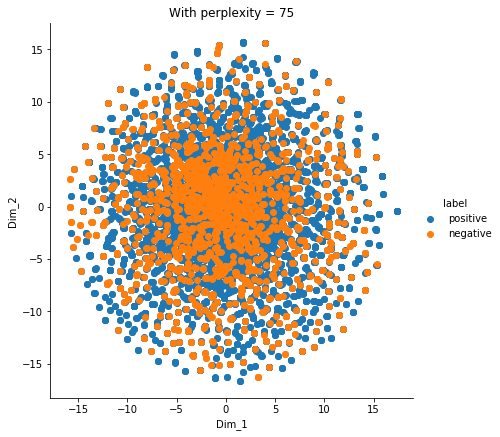

In [5]:
model = TSNE(n_jobs = 8, n_components=2, random_state=0, perplexity=75, n_iter=5000)
tsne_data = model.fit_transform(top_5000)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 75')
plt.show()

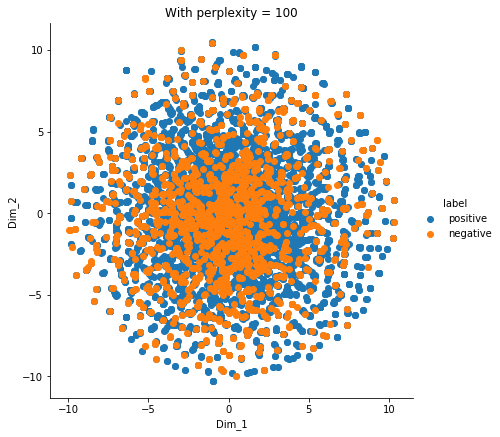

In [6]:
model = TSNE(n_jobs = 8, n_components=2, random_state=0, perplexity=100, n_iter=5000)
tsne_data = model.fit_transform(top_5000)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 100')
plt.show()

# Observations:

* At the first glance, all the plot looks overwhelmingly ambiguous because of the overlapping of the positive and negative points.

* Eventhough the plot for different perplexities with highest number of iterations are plotted, all the graphs are more or less similar. From this we can conclude the resulting plots as a stable.

* Because of the nature of BOW which is, it considers only the number of occurences of words in a sentence not the semantic meaning of the sentences; there is a high probability that points with a different meaning altogether can be placed closely. Ex: Consider review R1 - "This pizza is good" and review R2: 'This pizza is not good'. After removing the stopwords and stemming, both the sentences look same i.e., 'pizza good'. This can be a huge challenge while dealing with text data if BOW is used.